In [1]:
import polars as pl
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
class DataEngineering:
    def __init__(self, data):
        """
        Inicializa la clase con el DataFrame de Polars.
        :param data: DataFrame con los datos a procesar.
        """
        self.data = data

    def limpiar_fechas(self):
        """
        Normaliza y corrige los formatos de las columnas 'start_time' y 'end_time'.
        - Reemplaza '/' por '-' en las fechas.
        - Intenta parsear fechas en dos formatos: '%Y-%m-%d %H:%M:%S' y '%m-%d-%Y %H:%M'.
        """
        def unify_datetime_format(column):
            return column.str.replace_all("/", "-")

        # Reemplaza '/' por '-' en las fechas
        self.data = self.data.with_columns([
            unify_datetime_format(pl.col("start_time")).alias("start_time"),
            unify_datetime_format(pl.col("end_time")).alias("end_time")
        ])

        # Parseo de fechas con dos formatos posibles
        self.data = self.data.with_columns([
            pl.col("start_time")
            .str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S", strict=False)
            .alias("start_time_main"),
            pl.col("end_time")
            .str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S", strict=False)
            .alias("end_time_main"),
        ]).with_columns([
            # Maneja los nulos intentando otro formato
            pl.when(pl.col("start_time_main").is_null())
            .then(pl.col("start_time").str.strptime(pl.Datetime, format="%m-%d-%Y %H:%M", strict=False))
            .otherwise(pl.col("start_time_main")),
            pl.when(pl.col("end_time_main").is_null())
            .then(pl.col("end_time").str.strptime(pl.Datetime, format="%m-%d-%Y %H:%M", strict=False))
            .otherwise(pl.col("end_time_main"))
        ]).drop(["start_time_main", "end_time_main"])

    def calcular_distancia_km(self):
        """
        Calcula la distancia entre los puntos 'start_lat', 'start_lon' y 'end_lat', 'end_lon' en metros.
        """
        # Convierte las columnas de coordenadas a tipo float
        self.data = self.data.with_columns([
            pl.col("start_lat").cast(pl.Float64, strict=False),
            pl.col("start_lon").cast(pl.Float64, strict=False),
            pl.col("end_lat").cast(pl.Float64, strict=False),
            pl.col("end_lon").cast(pl.Float64, strict=False)
        ]).drop_nulls()  # Elimina registros con nulos

        try:
            self.data = self.data.filter(pl.col("passholder_type") != "NULL")     
        except:
            None
        # Conversión a GeoDataFrames y cálculo de distancia
        df_pd = self.data.to_pandas()
        gdf_start = gpd.GeoDataFrame(
            df_pd, geometry=gpd.points_from_xy(df_pd["start_lon"], df_pd["start_lat"]), crs="EPSG:4326"
        )
        gdf_end = gpd.GeoDataFrame(
            df_pd, geometry=gpd.points_from_xy(df_pd["end_lon"], df_pd["end_lat"]), crs="EPSG:4326"
        )

        # Convierte a metros y calcula distancia
        gdf_start, gdf_end = gdf_start.to_crs(epsg=3857), gdf_end.to_crs(epsg=3857)
        distancias_mts = round(gdf_start.geometry.distance(gdf_end.geometry), 1)

        # Agrega la distancia calculada al DataFrame
        self.data = self.data.with_columns(pl.Series(name="distancia_mts", values=distancias_mts))

    def agregar_franja_horaria(self):
        """
        Agrega la columna 'franja_horaria' según la hora de 'start_time'.
        """
        def categorizar_hora(hora):
            if 0 <= hora < 6:
                return "Madrugada"
            elif 6 <= hora < 12:
                return "Mañana"
            elif 12 <= hora < 18:
                return "Tarde"
            else:
                return "Noche"

        # Aplica la función para categorizar las horas
        self.data = self.data.with_columns(
            pl.col("start_time").dt.hour().map_elements(categorizar_hora, return_dtype=pl.String).alias("franja_horaria")
        )

    def agregar_estacion_del_ano(self):
        """
        Agrega la columna 'estacion_año' según el mes de 'start_time'.
        """
        def estacion_mes(mes):
            if mes in [12, 1, 2]:
                return "Invierno"
            elif mes in [3, 4, 5]:
                return "Primavera"
            elif mes in [6, 7, 8]:
                return "Verano"
            else:
                return "Otoño"

        # Aplica la función para determinar la estación
        self.data = self.data.with_columns(
            pl.col("start_time").dt.month().map_elements(estacion_mes, return_dtype=pl.String).alias("estacion_año")
        )

    def agregar_tiempo_promedio_estaciones(self):
        """
        Calcula y agrega el tiempo promedio de duración por estación y pares de estaciones.
        """
        # Tiempo promedio por estación de inicio
        duracion_promedio = (
            self.data.group_by("start_station")
            .agg(pl.col("duration").mean().alias("tiempo_promedio_estacion"))
        )
        self.data = self.data.join(duracion_promedio, on="start_station")

        # Tiempo promedio por pares de estaciones (inicio y fin)
        duracion_promedio_pares = (
            self.data.group_by(["start_station", "end_station"])
            .agg(pl.col("duration").mean().alias("tiempo_promedio_pares"))
        )
        self.data = self.data.join(duracion_promedio_pares, on=["start_station", "end_station"])

    def agregar_variables_adicionales(self):
        """
        Crea nuevas características adicionales para el análisis.
        - Día de la semana, hora de inicio.
        - Normalización de duración.
        - Velocidad promedio en metros por hora.
        - Indicador si la estación inicial y final son diferentes.
        - Frecuencia de viajes por día.
        - Duración promedio por tipo de usuario.
        - Frecuencia de uso de cada bicicleta.
        """
        # Extraer día y hora de inicio
        self.data = self.data.with_columns([
            pl.col("start_time").dt.weekday().alias("dia_semana"),
            pl.col("start_time").dt.hour().alias("hora_inicio")
        ])

        # Generar características adicionales
        self.data = self.data.with_columns([
            (pl.col("duration") / pl.col("duration").mean()).alias("duration_normalized"),
            (pl.col("distancia_mts") / (pl.col("duration") / 60)).alias("velocidad_promedio_mts"),
            (pl.col("start_station") != pl.col("end_station")).cast(pl.Int8).alias("diferente_estacion")
        ])

        # Frecuencia de viajes por día
        frecuencia_dia = (
            self.data.group_by("dia_semana")
            .agg(pl.len().alias("viajes_por_dia"))
        )
        self.data = self.data.join(frecuencia_dia, on="dia_semana")

        # Frecuencia de uso de cada bicicleta
        bike_usage = (
            self.data.group_by("bike_id")
            .agg(pl.len().alias("bike_usage"))
        )
        self.data = self.data.join(bike_usage, on="bike_id")

    def ejecutar(self):
        """
        Ejecuta todas las transformaciones secuenciales.
        """
        self.limpiar_fechas()
        self.calcular_distancia_km()
        self.agregar_franja_horaria()
        self.agregar_estacion_del_ano()
        self.agregar_tiempo_promedio_estaciones()
        self.agregar_variables_adicionales()
        return self.data

# Cargar datos
train = pl.read_csv("./Data/train_set.csv", ignore_errors=True)

In [3]:
data_engineer = DataEngineering(train)
train=data_engineer.ejecutar()

In [4]:
# Crear columnas 'año' y 'mes' a partir de 'start_time'
train = train.with_columns([
    pl.col("start_time").dt.year().alias("year"),
    pl.col("start_time").dt.month().alias("month")
])

# Calcular el promedio de plan_duration por 'año' y 'mes'
promedio_plan_mes = (
    train
    .group_by(["year", "month"])
    .agg(pl.mean("plan_duration").alias("promedio_plan_duration_mes"))
)

# Unir el promedio al DataFrame original
train = train.join(promedio_plan_mes, on=["year", "month"])

In [5]:
# Calcular el promedio de plan_duration por bike_id
promedio_plan_por_bicicleta = (
    train
    .group_by("bike_id")
    .agg(pl.mean("plan_duration").alias("promedio_plan_duration_bicicleta"))
)

# Unir el promedio al DataFrame original
train = train.join(promedio_plan_por_bicicleta, on="bike_id")

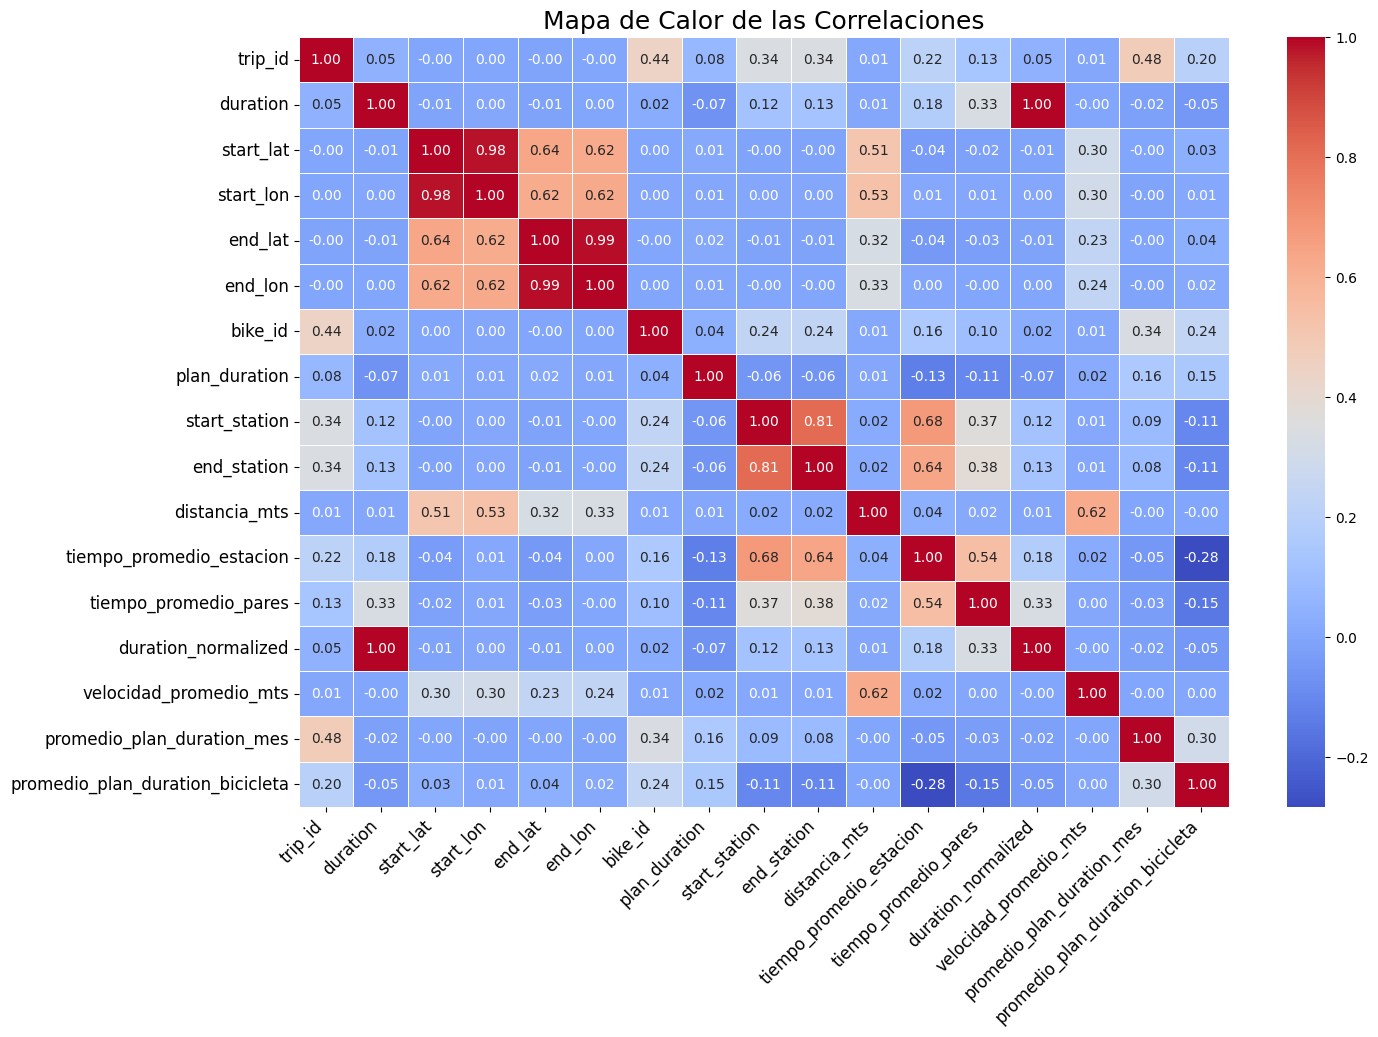

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

df_pandas = train.to_pandas()  # Asegúrate de usar tu DataFrame

# Seleccionar solo las columnas numéricas
df_numerico = df_pandas.select_dtypes(include=['float64', 'int64'])

# Eliminar filas con valores nulos
df_numerico_sin_nulos = df_numerico.dropna()

# Calcular la matriz de correlación
matriz_correlacion = df_numerico_sin_nulos.corr()

# Configurar el tamaño del gráfico
plt.figure(figsize=(15, 10))

# Crear el mapa de calor
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Título y ajustes
plt.title('Mapa de Calor de las Correlaciones', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Mostrar el gráfico
plt.show()

In [7]:
proporciones = (
    train
    .group_by("passholder_type")
    .agg(pl.count("trip_id").alias("conteo"))
    .with_columns(
        (pl.col("conteo") / pl.col("conteo").sum() * 100).alias("proporcion_porcentaje")
    )
    .sort("conteo", descending=True)  # Ordenar de mayor a menor por conteo
)

# Mostrar las proporciones
print(proporciones)

shape: (6, 3)
┌─────────────────┬────────┬───────────────────────┐
│ passholder_type ┆ conteo ┆ proporcion_porcentaje │
│ ---             ┆ ---    ┆ ---                   │
│ str             ┆ u32    ┆ f64                   │
╞═════════════════╪════════╪═══════════════════════╡
│ Monthly Pass    ┆ 387431 ┆ 57.344683             │
│ Walk-up         ┆ 203866 ┆ 30.174744             │
│ One Day Pass    ┆ 39885  ┆ 5.903484              │
│ Annual Pass     ┆ 32973  ┆ 4.880421              │
│ Flex Pass       ┆ 11420  ┆ 1.690304              │
│ Testing         ┆ 43     ┆ 0.006365              │
└─────────────────┴────────┴───────────────────────┘


##### Análisis de Feature Engineering

Durante el análisis exploratorio de datos (EDA), inicialmente seleccionamos características que proporcionan información relevante para predecir el tipo de pase (passholder_type). Estas variables incluían información temporal, espacial y de duración del viaje. Sin embargo, mediante transformaciones adicionales, logramos extraer nuevas características que capturan patrones más complejos y ofrecen mayor poder predictivo para los modelos.
Variables Finales Seleccionadas
Las características finales fueron cuidadosamente seleccionadas para equilibrar información numérica y categórica, asegurando un análisis robusto y un rendimiento óptimo del modelo.

#### **Variables Finales Seleccionadas**

| **Variable**                 | **Descripción**                                                                 |
|------------------------------|-------------------------------------------------------------------------------|
| `trip_id`                   | Identificador único del viaje.                                               |
| `duration`                  | Duración total del viaje (en minutos).                                       |
| `franja_horaria`            | Categoría temporal: Mañana, Tarde, Noche o Madrugada.                        |
| `tiempo_promedio_estacion`  | Duración promedio de viajes por estación.                                    |
| `distancia_mts`             | Distancia entre estaciones en metros.                                        |
| `estacion_año`              | Estación del año (Invierno, Primavera, Verano, Otoño).                       |
| `tiempo_promedio_pares`     | Duración promedio entre pares de estaciones (inicio-fin).                    |
| `dia_semana`                | Día de la semana en que ocurrió el viaje (0=Monday, 6=Sunday).               |
| `hora_inicio`               | Hora del día en la que inició el viaje.                                      |
| `duration_normalized`       | Duración normalizada respecto al promedio global.                           |
| `velocidad_promedio_mts`    | Velocidad promedio del viaje en metros por minuto.                           |
| `diferente_estacion`        | Indicador binario (0: misma estación, 1: estaciones distintas).              |
| `viajes_por_dia`            | Número de viajes agrupados por día de la semana.                             |
| `duracion_tipo_prom`        | Duración promedio del viaje según el tipo de pase.                           |
| `bike_usage`                | Frecuencia de uso de cada bicicleta.             


#### Justificación de las Variables Finales
1. Patrones Temporales: Variables como franja_horaria, estacion_año, dia_semana y hora_inicio permiten capturar comportamientos en diferentes momentos del día y a lo largo del año.
2. Comportamiento del Viaje: Características como duration, distancia_mts, tiempo_promedio_estacion, y tiempo_promedio_pares ofrecen información detallada sobre la eficiencia y desempeño del sistema.
Nuevas Variables Derivadas: Variables como duration_normalized y velocidad_promedio_mts permiten identificar viajes atípicos o anomalías en la duración y velocidad.
3. Frecuencia de Uso: Características como bike_usage y viajes_por_dia reflejan tendencias de uso del sistema y patrones de demanda.
Estas variables no solo maximizan la información disponible, sino que también permiten a los modelos capturar patrones complejos y ofrecer predicciones más precisas para el tipo de pase (passholder_type).

### 2. Modelos De Machine Learning

In [8]:
# Seleccionar solo las columnas numéricas
columnas_numericas = train.select(
    pl.col(pl.Int64, pl.Float64, pl.Int8, pl.UInt32, pl.Int32)
)

columnas_numericas.columns

['trip_id',
 'duration',
 'start_lat',
 'start_lon',
 'end_lat',
 'end_lon',
 'bike_id',
 'plan_duration',
 'start_station',
 'end_station',
 'distancia_mts',
 'tiempo_promedio_estacion',
 'tiempo_promedio_pares',
 'dia_semana',
 'hora_inicio',
 'duration_normalized',
 'velocidad_promedio_mts',
 'diferente_estacion',
 'viajes_por_dia',
 'bike_usage',
 'year',
 'month',
 'promedio_plan_duration_mes',
 'promedio_plan_duration_bicicleta']

In [9]:
# Ahora que ya extrajimos toda la información necesaria, podemos eliminar start_time y end_time
columns_delete = ["start_time", "end_time","trip_route_category","start_station","end_station","bike_id"]
train = train.drop(columns_delete)

train=train[["trip_id","duration", "franja_horaria", "tiempo_promedio_estacion", "distancia_mts", "estacion_año",
     "tiempo_promedio_pares","passholder_type", "dia_semana","hora_inicio", "duration_normalized", "velocidad_promedio_mts",
     "diferente_estacion","viajes_por_dia","bike_usage",'year','month','promedio_plan_duration_mes','promedio_plan_duration_bicicleta']]

In [10]:
cat_cols = ['franja_horaria', 'estacion_año']
num_cols = ['duration','tiempo_promedio_estacion','distancia_mts','tiempo_promedio_pares','dia_semana','hora_inicio',
            'duration_normalized','velocidad_promedio_mts','diferente_estacion','viajes_por_dia','bike_usage','year','month',
            'promedio_plan_duration_mes','promedio_plan_duration_bicicleta']

# Convertir a Pandas
train_df = train.to_pandas()

# Codificar la variable objetivo (target)
target_column = 'passholder_type'
label_encoder = LabelEncoder()
train_df[target_column] = label_encoder.fit_transform(train_df[target_column])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapping de etiquetas:", label_mapping)

Mapping de etiquetas: {'Annual Pass': np.int64(0), 'Flex Pass': np.int64(1), 'Monthly Pass': np.int64(2), 'One Day Pass': np.int64(3), 'Testing': np.int64(4), 'Walk-up': np.int64(5)}


In [11]:
# Separar características y etiquetas
X = train_df.drop(columns=[target_column])
y = train_df[target_column]

In [12]:
X= X.drop(columns=['trip_id'])

In [13]:
X

,duration,franja_horaria,tiempo_promedio_estacion,distancia_mts,estacion_año,tiempo_promedio_pares,dia_semana,hora_inicio,duration_normalized,velocidad_promedio_mts,diferente_estacion,viajes_por_dia,bike_usage,year,month,promedio_plan_duration_mes,promedio_plan_duration_bicicleta
0,35,Mañana,51.460177,0.0,Verano,105.734940,2,11,1.125629,0.000000,0,98285,108,2018,8,22.131152,24.814815
1,32,Tarde,30.540409,3478.1,Otoño,25.000000,7,17,1.029146,6521.437500,1,93496,321,2017,9,33.133468,42.383178
2,6,Mañana,22.503217,1144.4,Primavera,10.649899,1,9,0.192965,11444.000000,1,91958,107,2019,4,63.694287,35.121495
3,138,Mañana,28.814969,640.1,Otoño,15.428571,7,11,4.438193,278.304348,1,93496,149,2019,9,57.598374,54.946309
4,14,Tarde,23.273672,631.9,Invierno,16.974359,5,17,0.450251,2708.142857,1,102271,532,2020,1,76.216910,60.672932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675613,17,Noche,19.210279,3366.2,Primavera,16.286667,3,18,0.546734,11880.705882,1,95672,519,2018,4,26.739137,49.551060
675614,9,Tarde,37.070390,2398.0,Otoño,24.475655,2,16,0.289447,15986.666667,1,98285,783,2019,11,53.607584,65.892720
675615,6,Tarde,19.210279,164.0,Invierno,18.854962,6,15,0.192965,1640.000000,1,96619,355,2018,1,29.284998,35.188732
675616,3,Tarde,18.679805,717.5,Invierno,17.248322,1,14,0.096482,14350.000000,1,91958,338,2019,2,48.258915,41.038462


In [14]:
# Crear el ColumnTransformer
# # Crear el ColumnTransformer
ct = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])
ct = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('scaler', StandardScaler(), num_cols)
], remainder='passthrough')


In [15]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=24)

In [16]:
#===============// Proceso de Reducción de Dimensión //===================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Aplicar PCA y determinar el número de componentes
pca = PCA(n_components=0.95)  # Mantener el 95% de la varianza explicada

# Visualización del Scree Plot
def plot_scree(X, umbral=0.95):
    pca_temp = PCA()
    principalComponents = pca_temp.fit_transform(X)
    explained_variance_ratio = pca_temp.explained_variance_ratio_
    explained_variance_ratio_cumulative = np.cumsum(explained_variance_ratio)

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio_cumulative, marker='o', linestyle='--', label="Varianza Acumulada")
    plt.axhline(y=umbral, color='r', linestyle='--', label=f'Umbral {umbral*100:.0f}%')
    plt.xlabel('Número de Componentes')
    plt.ylabel('Varianza Explicada Acumulada')
    plt.title('Scree Plot')
    plt.grid()
    plt.legend()
    plt.show()

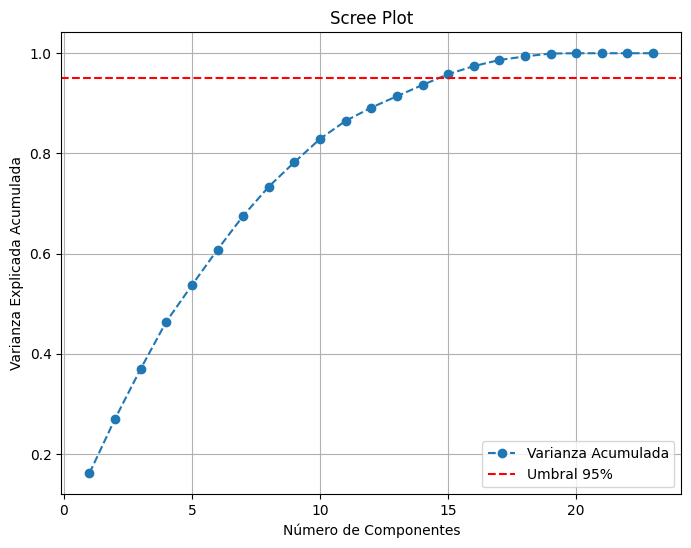

In [17]:
# Visualizar Scree Plot en los datos escalados
X_scaled = ct.fit_transform(X_train)
plot_scree(X_scaled)

In [18]:
from sklearn import svm

# Incorporar PCA al pipeline
pipe_lr = Pipeline([
    ('column_transformer', ct),
    ('pca', pca),
    ('LR', LogisticRegression(random_state=42, max_iter=500))
])

pipe_dt = Pipeline([
    ('column_transformer', ct),
    ('pca', pca),
    ('DT', DecisionTreeClassifier(random_state=42))
])

pipe_rf = Pipeline([
    ('column_transformer', ct),
    ('pca', pca),
    ('RF', RandomForestClassifier(random_state=42))
])

pipe_knn = Pipeline([
    ('column_transformer', ct),
    ('pca', pca),
    ('KNN', KNeighborsClassifier())
])

In [19]:
# Función para entrenar y evaluar los modelos
def fit_evaluate_pipelines(pipelines, X_train, X_test, y_train, y_test):
    """
    Entrena y evalúa varios pipelines, retornando un DataFrame con las métricas
    y un diccionario de matrices de confusión.
    """
    results_df = pd.DataFrame()  # Para guardar resultados
    confusion_mat_dict = {}  # Diccionario para matrices de confusión

    for name, pipeline in pipelines.items():
        # Entrenar el pipeline
        pipeline.fit(X_train, y_train)

        # Realizar predicciones
        y_pred = pipeline.predict(X_test)

        # Calcular métricas globales ponderadas (weighted)
        precision, recall, fscore, _ = precision_recall_fscore_support(
            y_test, y_pred, average='weighted', zero_division=0
        )
        accuracy = accuracy_score(y_test, y_pred)

        # Calcular matriz de confusión
        cm = confusion_matrix(y_test, y_pred)
        confusion_mat_dict[name] = cm

        # Crear DataFrame temporal con métricas globales
        temp_df = pd.DataFrame({
            'Modelo': [name],
            'Accuracy': [accuracy],
            'Precision(weighted)': [precision],
            'Recall(weighted)': [recall],
            'F1-Score(weighted)': [fscore]
        })

        # Concatenar resultados
        results_df = pd.concat([results_df, temp_df], ignore_index=True)

    # Establecer índice para el DataFrame
    results_df.set_index('Modelo', inplace=True)
    return results_df, confusion_mat_dict

In [20]:
# Diccionario de pipelines
pipelines = {
    'Logistic Regression': pipe_lr,
    'Decision Tree': pipe_dt,
    'Random Forest': pipe_rf,
    'KNN': pipe_knn,
    # 'SVM': pipe_svm
}

In [21]:
%%time
# Entrenar y evaluar
results_count, confusion_count = fit_evaluate_pipelines(pipelines, X_train, X_test, y_train, y_test)

# Mostrar resultados
print(results_count)

                     Accuracy  Precision(weighted)  Recall(weighted)  \
Modelo                                                                 
Logistic Regression  0.671354             0.623819          0.671354   
Decision Tree        0.573979             0.579290          0.573979   
Random Forest        0.702318             0.681891          0.702318   
KNN                  0.658619             0.625315          0.658619   

                     F1-Score(weighted)  
Modelo                                   
Logistic Regression            0.612905  
Decision Tree                  0.576579  
Random Forest                  0.656202  
KNN                            0.632411  
CPU times: total: 6min 34s
Wall time: 6min 27s


In [22]:
confusion_count

{'Logistic Regression': array([[   19,     0,  7816,     0,     0,   511],
        [    0,     0,  2639,     0,     0,   200],
        [   11,     0, 89347,     2,     0,  7373],
        [    1,     0,  4376,    10,     0,  5666],
        [    0,     0,     3,     0,     0,     9],
        [    2,     0, 26868,    33,     0, 24019]]),
 'Decision Tree': array([[ 1400,    15,  5077,   363,     0,  1491],
        [    8,   172,  1876,    66,     0,   717],
        [ 5487,  2326, 67018,  3526,     1, 18375],
        [  383,    61,  3217,  2054,     1,  4337],
        [    0,     0,     4,     1,     0,     7],
        [ 1435,   795, 17767,  4614,     7, 26304]]),
 'Random Forest': array([[  295,     0,  7495,    19,     0,   537],
        [    0,     7,  2485,     2,     0,   345],
        [  118,     4, 88492,   159,     0,  7960],
        [    8,     1,  3906,   610,     0,  5528],
        [    0,     0,     3,     0,     0,     9],
        [   42,     3, 21260,   396,     0, 29221]]),
 

CPU times: total: 10min 1s
Wall time: 5min 42s


<module 'matplotlib.pyplot' from 'C:\\Users\\jfgarcia\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

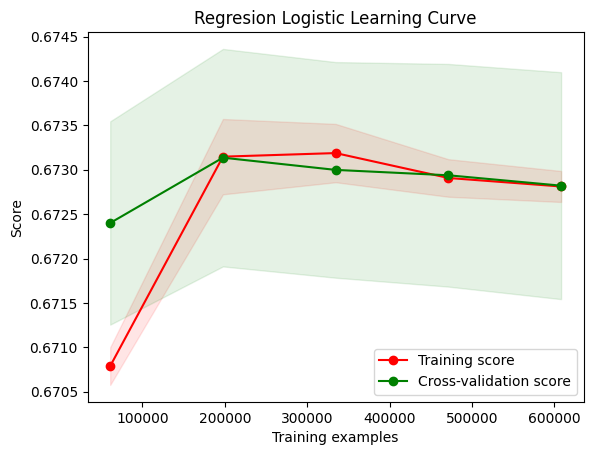

In [23]:
%%time
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, cv=None,train_sizes=np.linspace(.1, 1.0, 5)):
    #Establece el título y etiquetas sus ejes.
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes)
    
    #Métricas parav visualizar la variabilidad del rendimiento a través de las diferentes divisiones de la validación cruzada.
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt
    
plot_learning_curve(pipe_lr, "Regresion Logistic Learning Curve", X, y, cv=10)

CPU times: total: 4min 57s
Wall time: 4min 54s


<module 'matplotlib.pyplot' from 'C:\\Users\\jfgarcia\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

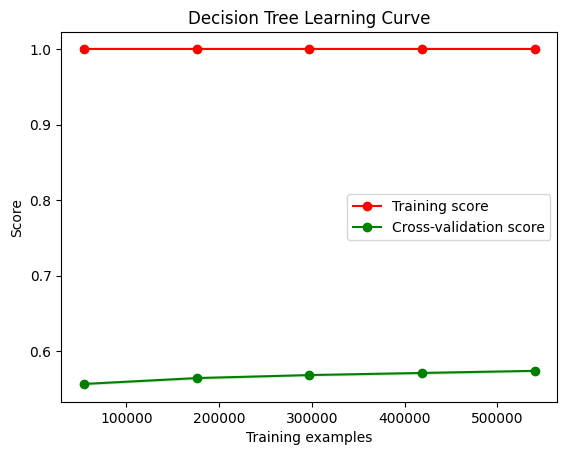

In [24]:
%%time
plot_learning_curve(pipe_dt, "Decision Tree Learning Curve", X, y, cv=10)

CPU times: total: 18min 47s
Wall time: 19min 1s


<module 'matplotlib.pyplot' from 'C:\\Users\\jfgarcia\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

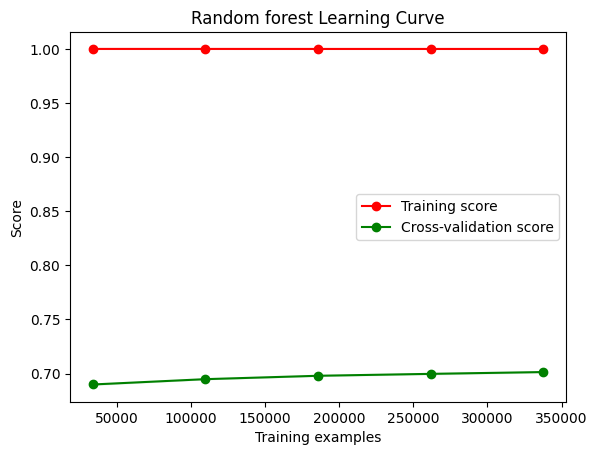

In [25]:
%%time
plot_learning_curve(pipe_rf, "Random forest Learning Curve", X, y, cv=10)

CPU times: total: 23min 17s
Wall time: 23min 44s


<module 'matplotlib.pyplot' from 'C:\\Users\\jfgarcia\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

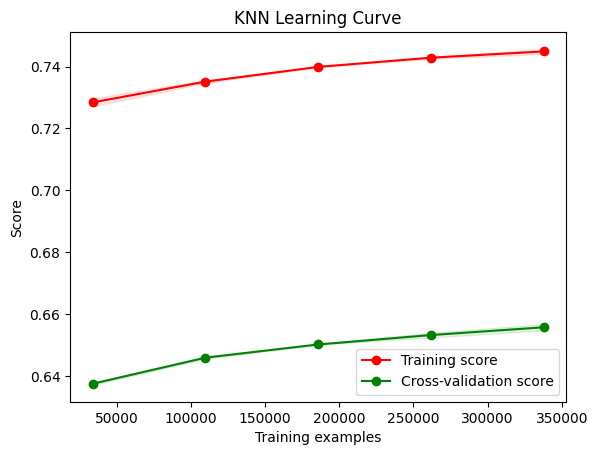

In [26]:
%%time
plot_learning_curve(pipe_knn, "KNN Learning Curve", X, y, cv=10)

### Curva ROC

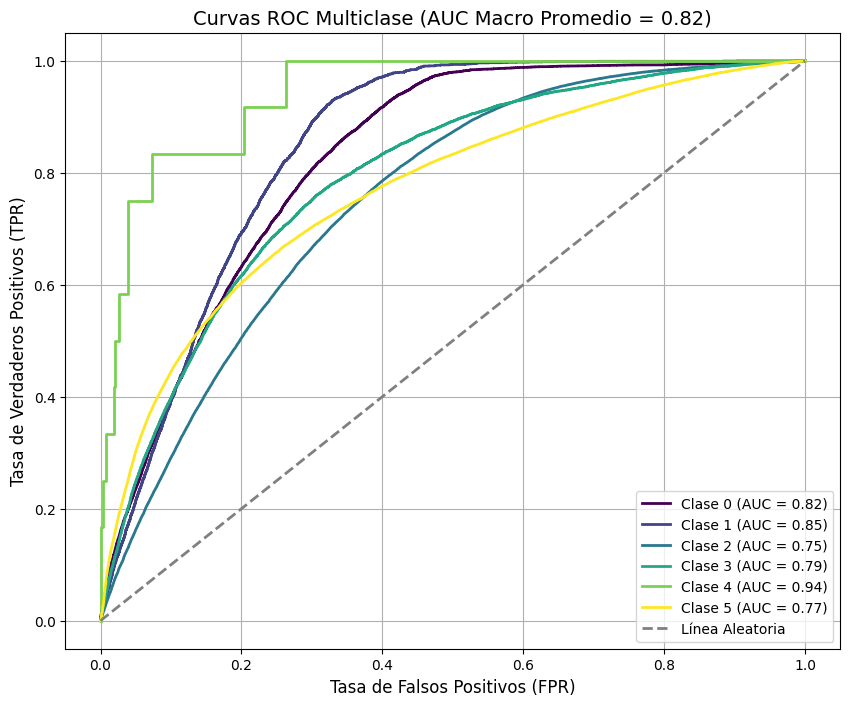

In [27]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm  # Para usar colormaps

# Binarizar las etiquetas verdaderas para multiclase
y_test_bin = label_binarize(y_test, classes=pipe_lr.classes_)
y_scores = pipe_lr.predict_proba(X_test)
n_classes = y_test_bin.shape[1]

# Calcular la Curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular el AUC Macro Promedio
auc_macro = roc_auc_score(y_test_bin, y_scores, average="macro", multi_class="ovr")

# Graficar las curvas ROC
plt.figure(figsize=(10, 8))

# Usar una paleta de colores 'viridis' para que sea más atractiva
colors = cm.viridis(np.linspace(0, 1, n_classes))

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label=f'Clase {pipe_lr.classes_[i]} (AUC = {roc_auc[i]:.2f})'
    )

# Línea aleatoria
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Línea Aleatoria')

# Configuración del gráfico
plt.title(f'Curvas ROC Multiclase (AUC Macro Promedio = {auc_macro:.2f})', fontsize=14)
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.grid()
plt.show()

### Turning Parameter

In [29]:
# Pipeline, Gridsearch, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

param_range = [1, 2, 3, 4, 5, 6]
param_range_fl = [1.0, 0.5, 0.1]
n_estimators = [50,100,150]
learning_rates = [.1,.2,.3]

cv_number = 10

lr_param_grid = [
    {'LR__penalty': ['l2'], 'LR__C': param_range_fl, 'LR__solver': ['newton-cg', 'lbfgs']},
    {'LR__penalty': ['l1'], 'LR__C': param_range_fl, 'LR__solver': ['liblinear']}
]
dt_param_grid = [{'DT__criterion': ['gini', 'entropy'],
                   'DT__min_samples_leaf': param_range,
                   'DT__max_depth': param_range,
                   'DT__min_samples_split': param_range[1:]}]
rf_param_grid = [{'RF__min_samples_leaf': param_range,
                   'RF__max_depth': param_range,
                   'RF__min_samples_split': param_range[1:]}]
knn_param_grid = [{'KNN__n_neighbors': param_range,
                   'KNN__weights': ['uniform', 'distance'],
                   'KNN__metric': ['euclidean', 'manhattan']}]
svm_param_grid = [{'SVM__kernel': ['linear', 'rbf'], 
                    'SVM__C': param_range}]


lr_grid_search = GridSearchCV(estimator=pipe_lr,
        param_grid=lr_param_grid,
        scoring='recall_weighted',
        cv=cv_number)
dt_grid_search = GridSearchCV(estimator=pipe_dt,
        param_grid=dt_param_grid,
        scoring='recall_weighted',
        cv=cv_number)
rf_grid_search = GridSearchCV(estimator=pipe_rf,
        param_grid=rf_param_grid,
        scoring='recall_weighted',
        cv=cv_number)
knn_grid_search = GridSearchCV(estimator=pipe_knn,
        param_grid=knn_param_grid,
        scoring='recall_weighted',
        cv=cv_number)


param_range = [1, 2, 3, 4, 5, 6]
param_range_fl = [1.0, 0.5, 0.1]
n_estimators = [50,100,150]
learning_rates = [.1,.2,.3]


def perform_grid_search(pipeline, param_grid, name, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='recall_weighted',
                               cv=cv_number)
    grid_search.fit(X_train, y_train)
    
    # Obtiene el pipeline con los mejores parámetros encontrados
    best_pipeline = grid_search.best_estimator_
    
    # Muestra la precisión del test y los mejores parámetros
    print(f'{name} Test Precision: {grid_search.score(X_test, y_test):.3f}')
    print(f'{name} Best Params: {grid_search.best_params_}')
    
    # Devuelve el pipeline con el modelo con los mejores hiperparámetros ya establecidos
    return best_pipeline


models_param_grid = {
    'Logistic Regression': (pipe_lr, lr_param_grid),
    # 'Decision Tree': (pipe_dt, dt_param_grid),
    # 'Random Forest': (pipe_rf, rf_param_grid),
    # 'K-Nearest Neighbors': (pipe_knn, knn_param_grid),
    # 'Support Vector Machines': (pipe_svm, svm_param_grid)
}

# Crear un diccionario para guardar los modelos ajustados
fitted_models = {}

# Ejecutar la búsqueda de cuadrícula para cada modelo y guardar el modelo configurado
for name, (pipeline, param_grid) in models_param_grid.items():
    fitted_models[name] = perform_grid_search(pipeline, param_grid, name, X_train, y_train, X_test, y_test)

C:\Users\jfgarcia\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jfgarcia\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Logistic Regression Test Precision: 0.671
Logistic Regression Best Params: {'LR__C': 1.0, 'LR__penalty': 'l2', 'LR__solver': 'newton-cg'}
